In [1]:
# Load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

In [3]:
# import os
# for root, dirs, files in os.walk('/home/gridedge23/Swapnil/Notebook/Covid19_global_forecasting'):
#     for filename in files:
#         #print(os.path.join(dirname, filename))
# #         print(filename)

In [2]:
# Read the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
# Check data
print(train_df.shape)
train_df.tail()

(25979, 6)


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
25974,35647,NaN,Zimbabwe,2020-04-09,11.0,3.0
25975,35648,NaN,Zimbabwe,2020-04-10,13.0,3.0
25976,35649,NaN,Zimbabwe,2020-04-11,14.0,3.0
25977,35650,NaN,Zimbabwe,2020-04-12,14.0,3.0
25978,35651,NaN,Zimbabwe,2020-04-13,17.0,3.0


In [4]:
print(test_df.shape)
test_df.head()

(13459, 4)


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [5]:
# Check for null values
train_df.isna().sum()


Id                    0
Province_State    14940
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [6]:
# Check for null values
test_df.isna().sum()

ForecastId           0
Province_State    7740
Country_Region       0
Date                 0
dtype: int64

In [9]:
#train_df['Province_State'].unique()

In [7]:
# Combining two data frame
all_data = pd.concat([train_df,test_df],axis=0,sort=False)
#all_data.tail()

# Fill Nan Values
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)


In [8]:
all_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
#all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])

all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year



In [10]:
all_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020


In [11]:
# Create train and test data
train = all_data[all_data['ForecastId']==-1.0]
test = all_data[all_data['ForecastId']!=-1.0]

In [12]:
print(train.shape)
train.head()

(25979, 11)


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020


In [13]:
train = train.drop(columns='Province_State',axis=1)
train['Country_Region'] = le.fit_transform(train['Country_Region'])
train.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,0,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,0,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,0,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,0,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,0,2020-01-26,0.0,0.0,-1.0,4,26,1,2020


In [ ]:
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore") 
  
#Fit auto_arima function
stepwise_fit = auto_arima(train['ConfirmedCases'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=484353.024, BIC=484393.847, Time=177.646 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=545034.308, BIC=545050.638, Time=2.476 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=494976.348, BIC=495009.006, Time=131.939 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=517772.794, BIC=517805.452, Time=129.951 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=545032.311, BIC=545040.476, Time=2.265 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=502136.846, BIC=502169.504, Time=9.986 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=484353.829, BIC=484402.816, Time=313.202 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting 

In [15]:
X = train[['Date','ConfirmedCases']]
X = X.set_index('Date')
X.head()

,ConfirmedCases
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


In [22]:

# from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima_model import ARIMA

# X = X.ConfirmedCases
# size = int(len(X) * 0.70)
# train, test1 = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions1 = list()
# for t in range(len(test1)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     predict = output[0]
#     predictions1.append(predict)
#     actual = test1[t]
#     history.append(actual)
#     print('Actual=%f, Predicted=%f' % (actual, predict))


In [23]:
# len(history),len(predictions1),len(test1)

In [24]:
# a = {'Actual cases':test1,
#         'Forecast ':predictions1}
# X_new = pd.DataFrame(data=a)
# X_new.head()

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
#train['ConfirmedCases'] = train['ConfirmedCases'].astype('int')
model = SARIMAX(X.values,  
                order = (1, 0, 1),  
                seasonal_order =(0, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                25979
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood             -242171.600
Date:                            Tue, 21 Apr 2020   AIC                         484351.199
Time:                                    12:30:31   BIC                         484383.858
Sample:                                         0   HQIC                        484361.751
                                          - 25979                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9477      0.000   2655.113      0.000       0.947       0.948
ma.L1         -0.0301      0.001    -43.229      0.000      -0.031      -0.029
ma.S.L12      -1.0000      0.001  -1313.775      0.000      -1.001      -0.999
sigma2      7.357e+06   1.04e-10    7.1e+16      0.000    7.36e+06    7.36e+06
===================================================================================
Ljung-Box (Q):                      115.08   Jarque-Bera (JB):        5845223399.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.70   Skew:                           -38.24
Prob(H) (two-sided):                  0.00   Kurtosis:                      2326.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.95e+29. Standard errors may be unstable.
"""

In [17]:
model.param_names

['ar.L1', 'ma.L1', 'ma.S.L12', 'sigma2']

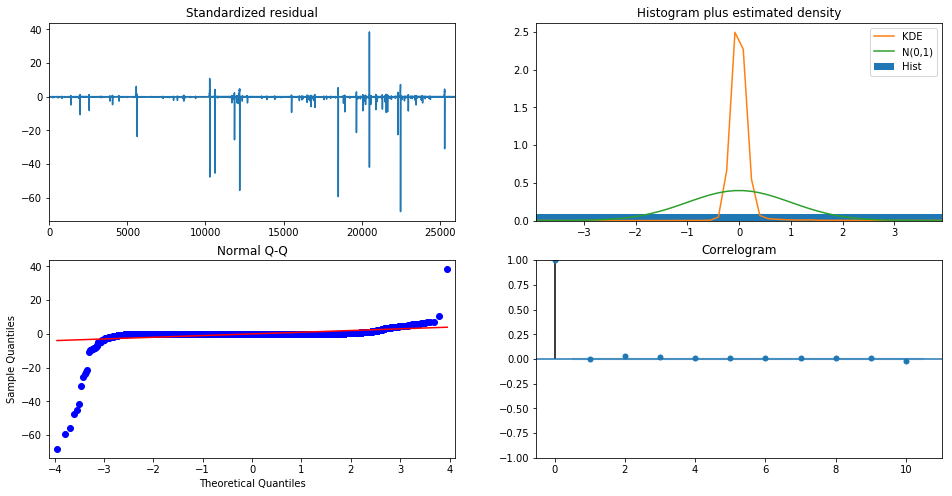

In [18]:
result.plot_diagnostics(figsize=(16, 8))
plt.show()

In [92]:
X.tail()

,ConfirmedCases
Date,
2020-04-09,11.0
2020-04-10,13.0
2020-04-11,14.0
2020-04-12,14.0
2020-04-13,17.0


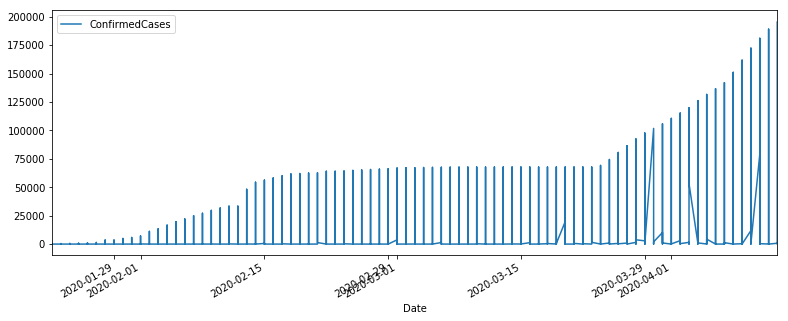

In [21]:
X.plot(figsize=(13, 5))

In [158]:
print(result.forecast(steps=30))

[ 107.49555855  177.68629135  250.58008863  347.92405875  419.6555433
  458.58040672  295.97263579  392.09573756  401.44544785  423.7570914
  439.45254597  532.23758164  592.37949767  637.2062898   686.06291646
  760.6270836   810.77036077  829.23628087  647.23975969  724.9883232
  716.92465452  722.73380081  722.78999224  800.75384371  846.84986135
  878.36548624  914.60724354  977.21641633 1016.03005657 1023.75898515]


In [104]:
# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
# fcast_res1 = result.get_forecast(steps=30)
# print(fcast_res1.summary_frame(alpha=0.10))

# Exp 2

In [82]:
# train and test data

tr_start,tr_end = '2020-01-22','2020-04-13'
te_start,te_end = '2020-04-14','2020-05-14'
tra = X['ConfirmedCases'][tr_start:tr_end]
tes = X['ConfirmedCases'][te_start:te_end]

In [83]:
#We can use ADF-test to check stationary of the data.
#ADF-test(Original-time-series)
import statsmodels.api as sm
res = sm.tsa.adfuller(X['ConfirmedCases'].dropna(),regression='ct')
print('p-value:{}'.format(res[0]))


p-value:-27.55470596643409


In [52]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(X['ConfirmedCases'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[0]))

p-value:-32.53062249678998


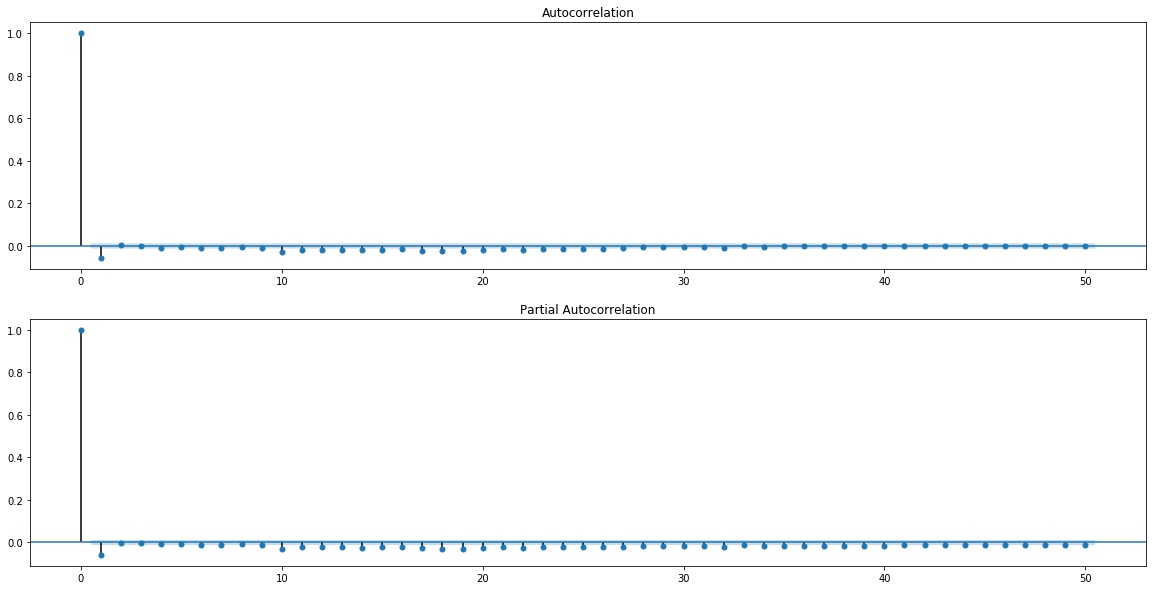

In [84]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(X.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(X.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [111]:
resDiff = sm.tsa.arma_order_select_ic(tra, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (4, 0) is the best.


In [114]:
arima = sm.tsa.statespace.SARIMAX(X,order=(1,0,1),
                                  seasonal_order=(0,1,1,12),
                                 enforce_stationarity=False, 
                                enforce_invertibility=False,).fit()
arima.summary()

/home/gridedge23/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/gridedge23/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/home/gridedge23/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/gridedge23/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     ConfirmedCases   No. Observations:                25979
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood             -244505.377
Date:                            Tue, 21 Apr 2020   AIC                         489018.754
Time:                                    15:56:46   BIC                         489051.410
Sample:                                         0   HQIC                        489029.305
                                          - 25979                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9476      0.000   3248.414      0.000       0.947       0.948
ma.L1         -0.0297      0.002    -19.386      0.000      -0.033      -0.027
ma.S.L12      -0.9981      0.001  -1085.891      0.000      -1.000      -0.996
sigma2      1.464e+07   2.17e-11   6.74e+17      0.000    1.46e+07    1.46e+07
===================================================================================
Ljung-Box (Q):                      115.80   Jarque-Bera (JB):        5813901038.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.69   Skew:                           -38.18
Prob(H) (two-sided):                  0.00   Kurtosis:                      2320.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+31. Standard errors may be unstable.
"""

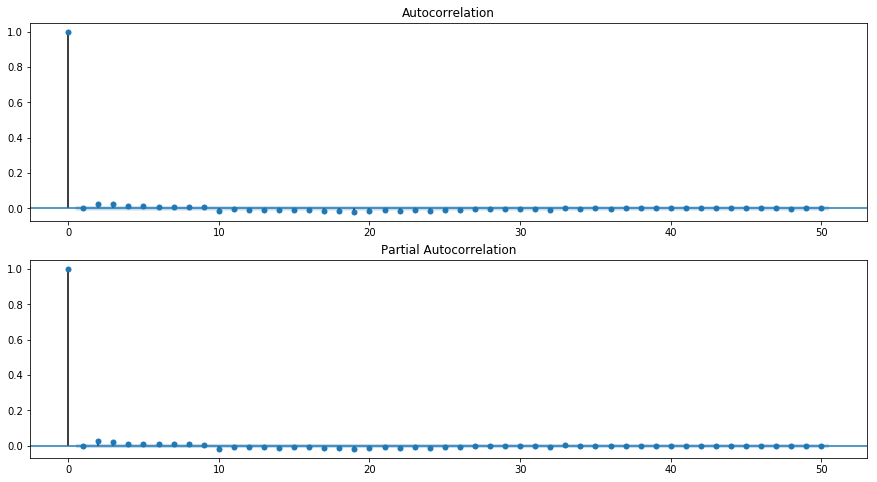

In [115]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [116]:
#train.groupby('Date')['ConfirmedCases'].max()
print(arima.forecast(steps=30))

25979     113.716396
25980     195.518210
25981     302.965231
25982     420.935982
25983     494.375427
25984     632.923420
25985     303.813545
25986     415.457497
25987     289.660500
25988     362.946311
25989     431.087570
25990     527.690356
25991     594.143684
25992     650.774107
25993     734.368562
25994     829.736471
25995     881.757322
25996    1000.008922
25997     651.666058
25998     745.084710
25999     602.017304
26000     658.937569
26001     711.570734
26002     793.477954
26003     846.005670
26004     889.440098
26005     960.529944
26006    1044.048409
26007    1084.840652
26008    1192.451954
dtype: float64


/home/gridedge23/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [118]:
pred = arima.predict(start='2020-04-01',end='2020-04-13')
pred

Date
2020-04-01    164.515346
2020-04-02    220.958863
2020-04-03    257.369968
2020-04-04    265.631723
2020-04-05    284.815299
2020-04-06    328.320738
2020-04-07    346.893057
2020-04-08    399.222948
2020-04-09    418.813497
2020-04-10    456.167664
2020-04-11    494.977884
2020-04-12    522.427044
2020-04-13    576.975698
dtype: float64

In [120]:
from sklearn.metrics import mean_squared_error
#pred = arima.predict(tr_end,te_end)[0:1]
#print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))


# Country US

In [128]:
# US data
US = train_df[train_df['Country_Region']=='US']
US.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
19671,27019,Alabama,US,2020-01-22,0.0,0.0
19672,27020,Alabama,US,2020-01-23,0.0,0.0
19673,27021,Alabama,US,2020-01-24,0.0,0.0
19674,27022,Alabama,US,2020-01-25,0.0,0.0
19675,27023,Alabama,US,2020-01-26,0.0,0.0


In [129]:
US.Province_State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [132]:
US.groupby('Province_State')['Date','ConfirmedCases'].max().sort_values(by='ConfirmedCases',ascending=False)

,Date,ConfirmedCases
Province_State,,
New York,2020-04-13,195749.0
Florida,2020-04-13,123019.0
New Jersey,2020-04-13,64584.0
Massachusetts,2020-04-13,26867.0
Michigan,2020-04-13,25635.0
Pennsylvania,2020-04-13,24292.0
California,2020-04-13,23931.0
Illinois,2020-04-13,22025.0
Louisiana,2020-04-13,21016.0


In [136]:
New_york = US[US['Province_State']=='New York']
New_york.head()
#New_york = New_york.set_index('Date')

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities
Date,,,,,
2020-01-22,30781,New York,US,0.0,0.0
2020-01-23,30782,New York,US,0.0,0.0
2020-01-24,30783,New York,US,0.0,0.0
2020-01-25,30784,New York,US,0.0,0.0
2020-01-26,30785,New York,US,0.0,0.0


In [160]:
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore") 
  
#Fit auto_arima function
stepwise_fit = auto_arima(New_york['ConfirmedCases'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 1, 1, 12) (constant=True); AIC=1123.310, BIC=1134.481, Time=1.649 seconds
Fit ARIMA: (0, 2, 0)x(0, 1, 0, 12) (constant=True); AIC=1123.340, BIC=1127.809, Time=0.035 seconds
Fit ARIMA: (1, 2, 0)x(1, 1, 0, 12) (constant=True); AIC=1124.420, BIC=1133.356, Time=0.914 seconds
Fit ARIMA: (0, 2, 1)x(0, 1, 1, 12) (constant=True); AIC=1121.209, BIC=1130.145, Time=1.553 seconds
Fit ARIMA: (0, 2, 0)x(0, 1, 0, 12) (constant=False); AIC=1121.384, BIC=1123.619, Time=0.098 seconds
Fit ARIMA: (0, 2, 1)x(0, 1, 0, 12) (constant=True); AIC=1125.399, BIC=1132.101, Time=0.040 seconds
Fit ARIMA: (0, 2, 1)x(1, 1, 1, 12) (constant=True); AIC=1122.916, BIC=1134.086, Time=2.902 seconds
Fit ARIMA: (0, 2, 1)x(0, 1, 2, 12) (constant=True); AIC=1122.626, BIC=1133.797, Time=5.381 seconds
Fit ARIMA: (0, 2, 1)x(1, 1, 0, 12) (constant=True); AIC=1124.565, BIC=1133.502, Time=0.687 seconds
Fit ARIMA: (0, 2, 1)x(1, 1, 2, 12) (constant=True); AIC=1124.310,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   83
Model:             SARIMAX(0, 2, 0)x(0, 1, [1], 12)   Log Likelihood                -556.633
Date:                              Tue, 21 Apr 2020   AIC                           1119.267
Time:                                      17:18:28   BIC                           1125.969
Sample:                                           0   HQIC                          1121.926
                                               - 83                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.2746     53.726      0.340      0.734     -87.026     123.575
ma.S.L12      -0.5567      0.115     -4.845      0.000      -0.782      -0.332
sigma2       5.76e+05   6.59e+04      8.738      0.000    4.47e+05    7.05e+05
===================================================================================
Ljung-Box (Q):                       24.43   Jarque-Bera (JB):                72.25
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):            2537.77   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
arima1 = sm.tsa.statespace.SARIMAX(New_york['ConfirmedCases'],order=(0,2,0),
                                  seasonal_order=(0,1,1,12),
                                 enforce_stationarity=False, 
                                enforce_invertibility=False).fit()
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       ConfirmedCases   No. Observations:                   83
Model:             SARIMAX(0, 2, 0)x(0, 1, [1], 12)   Log Likelihood                -456.780
Date:                              Tue, 21 Apr 2020   AIC                            917.560
Time:                                      17:19:16   BIC                            921.611
Sample:                                  01-22-2020   HQIC                           919.130
                                       - 04-13-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6363      0.115     -5.526      0.000      -0.862      -0.411
sigma2      6.951e+05   8.26e+04      8.413      0.000    5.33e+05    8.57e+05
===================================================================================
Ljung-Box (Q):                       20.78   Jarque-Bera (JB):                30.30
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
print(arima1.forecast(steps=30))

2020-04-14    202734.825518
2020-04-15    210615.167262
2020-04-16    218842.262197
2020-04-17    226456.994216
2020-04-18    233908.750305
2020-04-19    241582.209332
2020-04-20    250403.750931
2020-04-21    259183.320964
2020-04-22    267914.872167
2020-04-23    275911.516389
2020-04-24    284476.739155
2020-04-25    292335.916202
2020-04-26    300464.918767
2020-04-27    309488.437557
2020-04-28    318858.709540
2020-04-29    327616.618605
2020-04-30    336211.551741
2020-05-01    345028.187815
2020-05-02    354992.906461
2020-05-03    364915.653540
2020-05-04    374790.381790
2020-05-05    383930.203059
2020-05-06    393638.602872
2020-05-07    402640.956966
2020-05-08    411913.136577
2020-05-09    422079.832415
2020-05-10    432593.281444
2020-05-11    442494.367556
2020-05-12    452232.477739
2020-05-13    462192.290859
Freq: D, dtype: float64


Text(0.5, 1.0, 'Forecast Confirmed Cases New York')

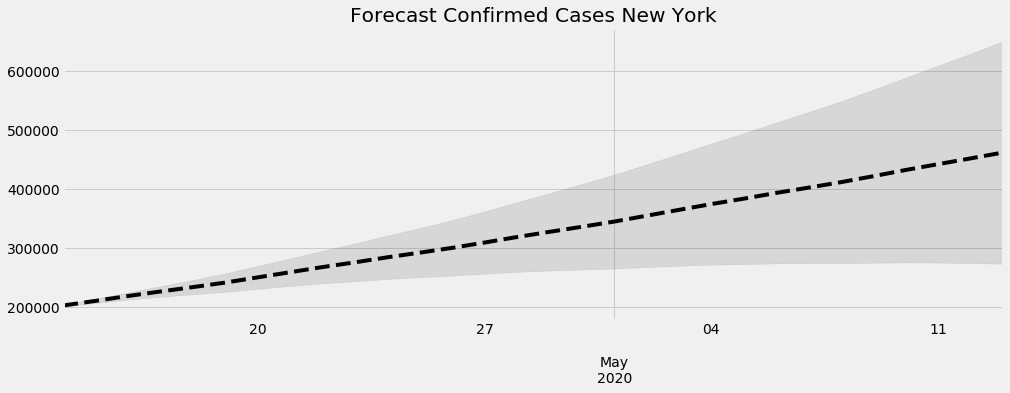

In [185]:
# Forecast Result
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 5))
fcast = arima1.get_forecast(steps=30).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Forecast Confirmed Cases New York')


Text(0.5, 1.0, 'Actual Confirmed Cases New York')

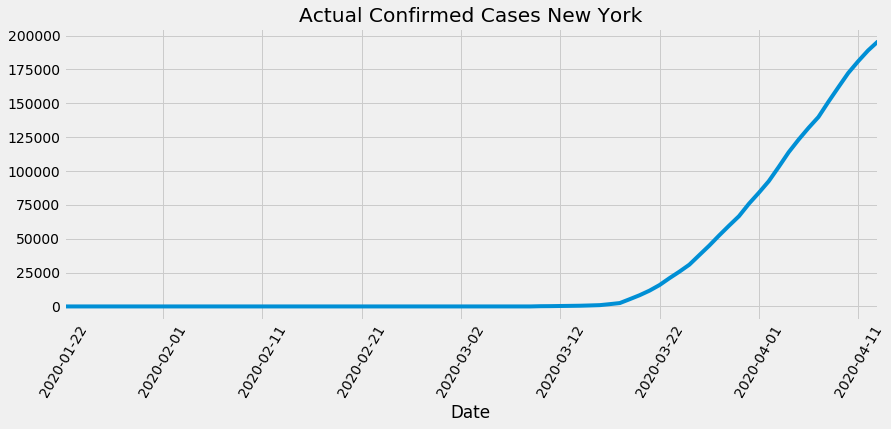

In [186]:
# Actual Data
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13,5))
New_york.ConfirmedCases.plot()
plt.xticks(rotation=60)
plt.title('Actual Confirmed Cases New York')

# Country India

In [142]:
India = train_df[train_df['Country_Region']=='India']
India = India.drop(columns='Province_State',axis=1)
India.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
11620,15961,India,2020-01-22,0.0,0.0
11621,15962,India,2020-01-23,0.0,0.0
11622,15963,India,2020-01-24,0.0,0.0
11623,15964,India,2020-01-25,0.0,0.0
11624,15965,India,2020-01-26,0.0,0.0


In [144]:
India.groupby('Date')['ConfirmedCases','Fatalities'].max().sort_values(by='ConfirmedCases',ascending=False)

,ConfirmedCases,Fatalities
Date,,
2020-04-13,10453.0,358.0
2020-04-12,9205.0,331.0
2020-04-11,8446.0,288.0
2020-04-10,7598.0,246.0
2020-04-09,6725.0,226.0
2020-04-08,5916.0,178.0
2020-04-07,5311.0,150.0
2020-04-06,4778.0,136.0
2020-04-05,3588.0,99.0


In [145]:
India = India.set_index('Date')

In [164]:
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore") 
  
#Fit auto_arima function
stepwise_fit = auto_arima(India['ConfirmedCases'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 1, 1, 12) (constant=True); AIC=874.676, BIC=885.846, Time=1.570 seconds
Fit ARIMA: (0, 2, 0)x(0, 1, 0, 12) (constant=True); AIC=893.974, BIC=898.442, Time=0.035 seconds
Fit ARIMA: (1, 2, 0)x(1, 1, 0, 12) (constant=True); AIC=886.844, BIC=895.780, Time=0.652 seconds
Fit ARIMA: (0, 2, 1)x(0, 1, 1, 12) (constant=True); AIC=872.676, BIC=881.612, Time=1.279 seconds
Fit ARIMA: (0, 2, 0)x(0, 1, 0, 12) (constant=False); AIC=892.232, BIC=894.467, Time=0.043 seconds
Fit ARIMA: (0, 2, 1)x(0, 1, 0, 12) (constant=True); AIC=870.678, BIC=877.381, Time=0.176 seconds
Fit ARIMA: (0, 2, 1)x(1, 1, 0, 12) (constant=True); AIC=872.676, BIC=881.612, Time=0.862 seconds
Fit ARIMA: (0, 2, 1)x(1, 1, 1, 12) (constant=True); AIC=874.647, BIC=885.817, Time=1.285 seconds
Near non-invertible roots for order (0, 2, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (1, 2, 1)x

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   83
Model:             SARIMAX(1, 2, 2)x(0, 1, [], 12)   Log Likelihood                -425.078
Date:                             Tue, 21 Apr 2020   AIC                            860.156
Time:                                     17:20:24   BIC                            871.326
Sample:                                          0   HQIC                           864.588
                                              - 83                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4552      9.491      0.364      0.716     -15.146      22.057
ar.L1          0.5387      0.112      4.799      0.000       0.319       0.759
ma.L1         -1.6794      0.355     -4.730      0.000      -2.375      -0.984
ma.L2          0.9958      0.405      2.458      0.014       0.202       1.790
sigma2      1.196e+04   4723.090      2.532      0.011    2699.715    2.12e+04
===================================================================================
Ljung-Box (Q):                       27.54   Jarque-Bera (JB):               450.77
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             256.58   Skew:                             2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
arima2 = sm.tsa.statespace.SARIMAX(India['ConfirmedCases'],order=(1,2,2),
                                  seasonal_order=(0,1,0,12),
                                 enforce_stationarity=False, 
                                enforce_invertibility=False).fit()
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      ConfirmedCases   No. Observations:                   83
Model:             SARIMAX(1, 2, 2)x(0, 1, [], 12)   Log Likelihood                -407.689
Date:                             Tue, 21 Apr 2020   AIC                            823.378
Time:                                     17:21:04   BIC                            832.137
Sample:                                 01-22-2020   HQIC                           826.839
                                      - 04-13-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5531      0.074      7.518      0.000       0.409       0.697
ma.L1         -1.6846      0.079    -21.375      0.000      -1.839      -1.530
ma.L2          1.0000      0.072     13.948      0.000       0.859       1.141
sigma2      1.258e+04   1.07e-05   1.18e+09      0.000    1.26e+04    1.26e+04
===================================================================================
Ljung-Box (Q):                       26.83   Jarque-Bera (JB):               383.83
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):          167524.40   Skew:                             2.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+24. Standard errors may be unstable.
"""

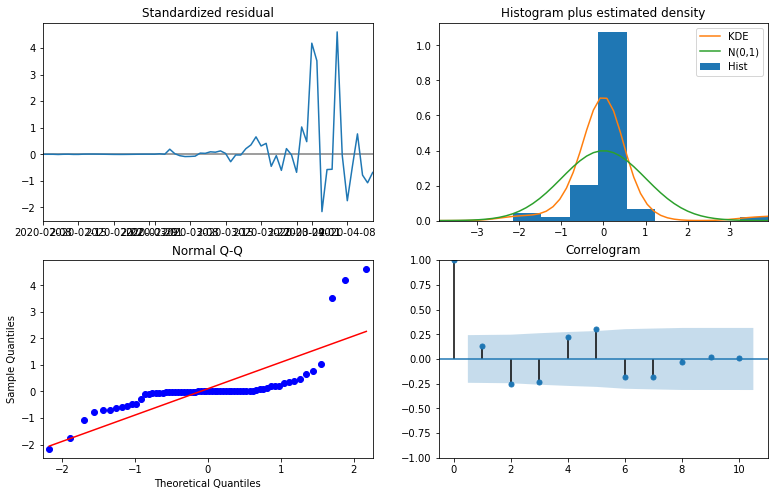

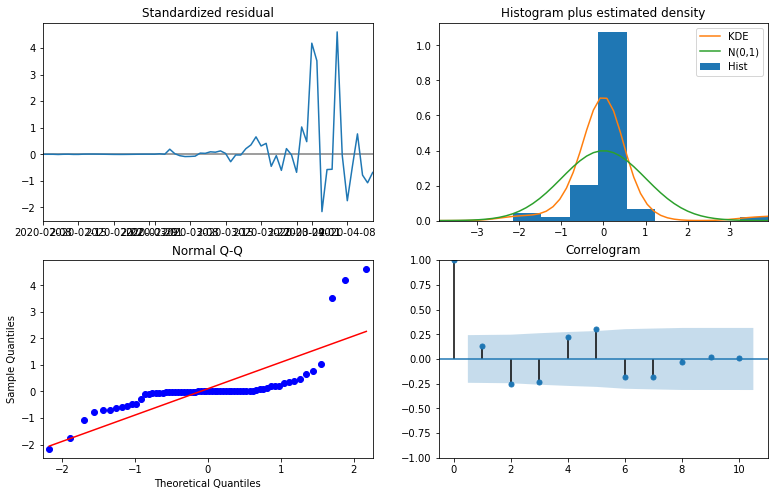

In [166]:
arima2.plot_diagnostics(figsize=(13,8))

In [175]:
arima2.forecast(steps=30)

2020-04-14    11674.435520
2020-04-15    12315.395278
2020-04-16    13414.461703
2020-04-17    14486.336326
2020-04-18    16232.149893
2020-04-19    17315.399148
2020-04-20    18467.571036
2020-04-21    19822.040973
2020-04-22    21239.569639
2020-04-23    22631.577730
2020-04-24    23934.297915
2020-04-25    25725.858872
2020-04-26    27490.767288
2020-04-27    28675.151239
2020-04-28    30317.614922
2020-04-29    31932.871906
2020-04-30    34222.059595
2020-05-01    35848.678416
2020-05-02    37544.217350
2020-05-03    39442.052939
2020-05-04    41402.946486
2020-05-05    43338.319032
2020-05-06    45184.403437
2020-05-07    47519.328483
2020-05-08    49827.600916
2020-05-09    51555.348844
2020-05-10    53741.176481
2020-05-11    55899.797408
2020-05-12    58732.349033
2020-05-13    60902.331786
Freq: D, dtype: float64

Text(0.5, 1.0, 'Forecast Confirmed Cases India')

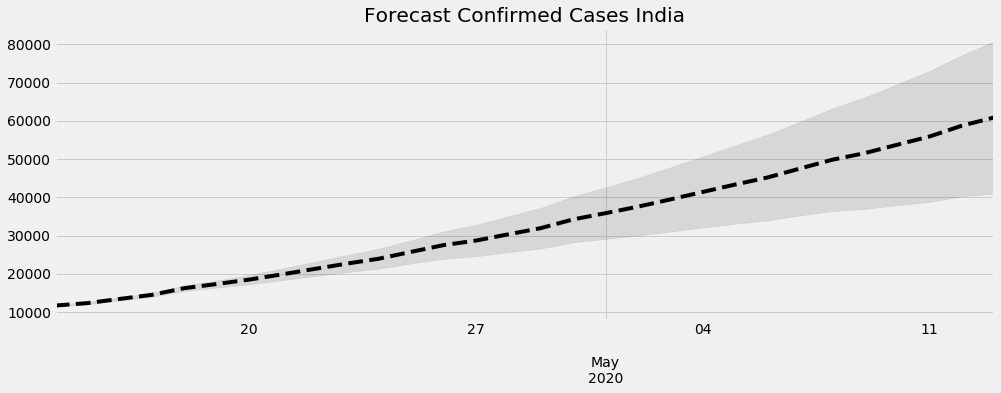

In [184]:
# Forecast Result
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 5))
fcast = arima2.get_forecast(steps=30).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Forecast Confirmed Cases India')


Text(0.5, 1.0, 'Actual Confirmed Cases India')

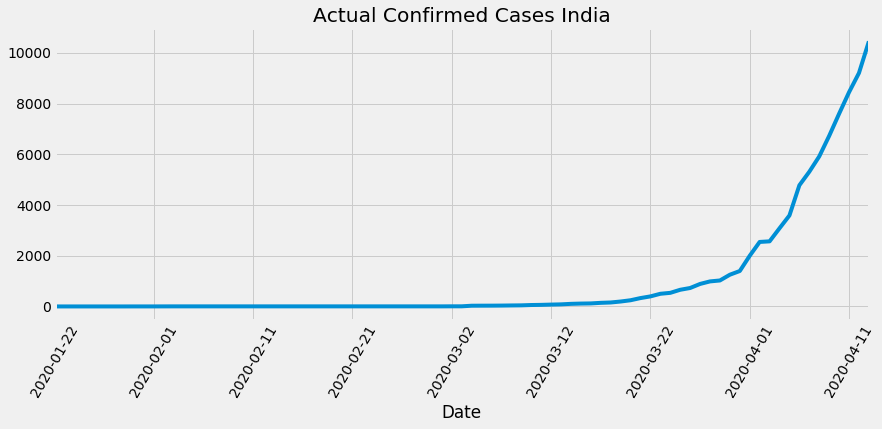

In [183]:
# Actual Data
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13,5))
India.ConfirmedCases.plot()
plt.xticks(rotation=60)
plt.title('Actual Confirmed Cases India')

In [94]:
# Total cases over the world 
temp = train.groupby('Date')['ConfirmedCases', 'Fatalities'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['ConfirmedCases', 'Fatalities'],
                 var_name='case', value_name='count')

fig = px.line(temp, x="Date", y="count", color='case',
              title='Total cases over the Date ', color_discrete_sequence = ['cyan', 'red'])
fig.show()

In [90]:
# Maximum confirmed and fatalities case on 2020-04-13
country_max = train.groupby(['Date','Country_Region'])['ConfirmedCases', 'Fatalities'].max().reset_index().sort_values(by='ConfirmedCases',ascending=False).groupby('Country_Region').max().reset_index().sort_values(by='ConfirmedCases',ascending=False)
country_max[:20].style.background_gradient(cmap='viridis_r')

,Country_Region,Date,ConfirmedCases,Fatalities
171,US,2020-04-13 00:00:00,195749,10058
156,Spain,2020-04-13 00:00:00,170099,17756
84,Italy,2020-04-13 00:00:00,159516,20465
61,France,2020-04-13 00:00:00,136779,14967
65,Germany,2020-04-13 00:00:00,130072,3194
175,United Kingdom,2020-04-13 00:00:00,88621,11329
80,Iran,2020-04-13 00:00:00,73303,4585
36,China,2020-04-13 00:00:00,67803,3221
170,Turkey,2020-04-13 00:00:00,61049,1296
16,Belgium,2020-04-13 00:00:00,30589,3903


In [32]:
# Getting Top country cases 
Top_country = train.groupby('Country_Region')['ConfirmedCases','Fatalities'].max().reset_index().sort_values(by='ConfirmedCases',ascending=False).head(15)

# confirmed - deaths
fig_c = px.bar(Top_country.sort_values('ConfirmedCases'), x="ConfirmedCases", y="Country_Region", 
               text='ConfirmedCases', orientation='h', color_discrete_sequence = ['cyan'])

fig_d = px.bar(Top_country.sort_values('Fatalities'), x="Fatalities", y="Country_Region", 
               text='Fatalities', orientation='h', color_discrete_sequence = ['red'])


fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.14, vertical_spacing=0.08,
                    subplot_titles=('Confirmedcases', 'Fatalities'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)


In [64]:
# Rise of Confirmed Cases around top 10 countries

countries = Top_country.Country_Region.unique().tolist()
df_plot = train.loc[(train.Country_Region.isin(countries[0:10])) & (train.Date >= '2020-03-01')][['Date', 'Country_Region', 'ConfirmedCases', 'Fatalities']].groupby(['Date', 'Country_Region']).max().reset_index()
df_plot = df_plot.groupby(['Date', 'Country_Region']).sum().sort_values(by='ConfirmedCases', ascending=False).reset_index()
#df_plot

fig = px.bar(df_plot, x="Date", y="ConfirmedCases", color="Country_Region", barmode="stack",)
fig.update_layout(title='Rise of Confirmed Cases around top 10 countries', annotations=[dict(x='2020-03-22', y=150, xref="x", yref="y", text="Corona Rise exponentially from here", showarrow=True, arrowhead=1, ax=-150, ay=-150)])
fig.show()


In [65]:
# Dsitribution over the world

formated_gdf = train.groupby(['Date', 'Country_Region'])['ConfirmedCases', 'Fatalities'].max().reset_index()
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
#formated_gdf['size'] = formated_gdf['ConfirmedCases'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country_Region", locationmode='country names', 
                     color="ConfirmedCases", hover_name="Country_Region", 
                     range_color= [0, 1500], 
                     projection="natural earth", animation_frame="Date", 
                     title='COVID-19: Spread Over World', color_continuous_scale="portland")

fig.show()

In [18]:
# Apply label encoding
train['Province_State'] = le.fit_transform(train['Province_State'])
train['Country_Region'] = le.fit_transform(train['Country_Region'])

test['Province_State'] = le.fit_transform(test['Province_State'])
test['Country_Region'] = le.fit_transform(test['Country_Region'])

# Creating train data
X = train.drop(columns=['Id','ConfirmedCases','Fatalities','Date','ForecastId'],axis=1)
cases = train.ConfirmedCases
fatalities = train.Fatalities

x_test = test.drop(columns=['Id','ConfirmedCases','Fatalities','Date','ForecastId'],axis=1)

/home/gridedge23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/gridedge23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/gridedge23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [19]:
model = XGBRegressor(n_estimators = 1000 , random_state = 0 , max_depth = 15)
model.fit(X,cases)
cases_pred = model.predict(x_test)

model1 = XGBRegressor(n_estimators = 1000 , random_state = 0 , max_depth = 15)
model1.fit(X,fatalities)
fatalities_pred = model1.predict(x_test)


/home/gridedge23/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/gridedge23/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[12:39:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [21]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
# Getting Accuracy value
MSE = mean_squared_error(cases.iloc[0:13459],cases_pred)
RMSE = sqrt(mean_squared_error(cases.iloc[0:13459],cases_pred))
MAE = mean_absolute_error(cases.iloc[0:13459],cases_pred)
R2 = r2_score(cases.iloc[0:13459],cases_pred)

print('Mean squared error :', MSE)
print('Root mean squared error :',RMSE)
print('Mean absolute error :', MAE)
print('R squared :',R2)

Mean squared error : 552617901.9467754
Root mean squared error : 23507.826397750505
Mean absolute error : 6668.169310175872
R squared : -6.398942469416935


In [127]:
x_test.shape,test_df.shape

((13459, 6), (13459, 4))

In [23]:
# Predicted Result
test_df_predict = test_df.copy()
test_df_predict['Confirmedcase'] = cases_pred
test_df_predict['Fatalities'] = fatalities_pred
test_df_predict = test_df_predict.drop('Province_State',axis=1)
test_df_predict.to_csv('Forecast_result.csv')

In [134]:
test_df_predict.head(15)

,ForecastId,Country_Region,Date,Confirmedcase,Fatalities
0,1,Afghanistan,2020-04-02,272.994507,5.996530
1,2,Afghanistan,2020-04-03,281.001801,6.000327
2,3,Afghanistan,2020-04-04,299.004059,7.001165
3,4,Afghanistan,2020-04-05,349.000305,6.997691
4,5,Afghanistan,2020-04-06,366.999847,11.002952
5,6,Afghanistan,2020-04-07,422.998779,13.998834
6,7,Afghanistan,2020-04-08,444.000305,13.998931
7,8,Afghanistan,2020-04-09,483.999359,15.001740
8,9,Afghanistan,2020-04-10,521.000732,15.000447
9,10,Afghanistan,2020-04-11,554.998596,17.999535


In [124]:
US = test_df_predict[test_df_predict['Country_Region']=='US']
US.groupby('Date')['Confirmedcase','Fatalities'].sum().reset_index()

,Date,Confirmedcase,Fatalities
0,2020-04-02,243440.96875,5921.984863
1,2020-04-03,275425.96875,7083.002930
2,2020-04-04,308693.03125,8402.994141
3,2020-04-05,336911.96875,9615.022461
4,2020-04-06,366507.03125,10778.999023
5,2020-04-07,396063.12500,12716.993164
6,2020-04-08,428888.93750,14690.001953
7,2020-04-09,461273.93750,16472.986328
8,2020-04-10,496372.18750,18581.021484
9,2020-04-11,526232.87500,20457.986328


In [120]:
# Forecasting Comparison by date
temp = test_df_predict.groupby('Date')['Confirmedcase', 'Fatalities'].max().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Confirmedcase', 'Fatalities'],
                 var_name='case', value_name='count')

fig = px.area(temp, x="Date", y="count", color='case',
              title='Forecasting cases over the Date ', color_discrete_sequence = ['cyan', 'red'])
fig.show()

In [119]:
test_df_predict.groupby(['Date','Country_Region'])['Confirmedcase','Fatalities'].max().reset_index().head(10)
                                                                                                    

#test_df_predict.sort_values(by='Confirmedcase',ascending=False).head(10)

,Date,Country_Region,Confirmedcase,Fatalities
0,2020-04-02,Afghanistan,272.994507,5.996530
1,2020-04-02,Albania,277.005341,16.003819
2,2020-04-02,Algeria,986.005493,85.998611
3,2020-04-02,Andorra,427.980103,15.007656
4,2020-04-02,Angola,8.009960,1.999878
5,2020-04-02,Antigua and Barbuda,9.011209,0.000715
6,2020-04-02,Argentina,1132.979614,35.988228
7,2020-04-02,Armenia,663.017517,6.999049
8,2020-04-02,Australia,2298.006836,10.001014
9,2020-04-02,Austria,11129.036133,157.995422


In [102]:
test_df_predict.groupby('Country_Region')['Confirmedcase', 'Fatalities'].sum().reset_index().sort_values(by='Confirmedcase',ascending=False).head(15)


,Country_Region,Confirmedcase,Fatalities
171,US,2.623370e+07,899603.937500
156,Spain,7.000430e+06,721846.312500
84,Italy,6.600535e+06,842538.437500
61,France,5.553830e+06,590999.750000
65,Germany,5.351928e+06,124925.531250
36,China,3.573037e+06,143722.765625
175,United Kingdom,3.505410e+06,435058.812500
80,Iran,3.027100e+06,189006.000000
170,Turkey,2.344600e+06,49727.351562
16,Belgium,1.224812e+06,148175.000000


In [103]:
# Top 10 forecast result
top_country = test_df_predict.groupby('Country_Region')['Confirmedcase', 'Fatalities'].max().reset_index().sort_values(by='Confirmedcase',ascending=False).head(15)

# confirmed - Fatalities
fig_c = px.bar(top_country.sort_values('Confirmedcase'), x="Confirmedcase", y="Country_Region", 
               text='Confirmedcase', orientation='h', color_discrete_sequence = ['cyan'])

fig_d = px.bar(top_country.sort_values('Fatalities'), x="Fatalities", y="Country_Region", 
               text='Fatalities', orientation='h', color_discrete_sequence = ['red'])


fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.14, vertical_spacing=0.08,
                    subplot_titles=('Confirmedcase', 'Fatalities'),)

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)

In [118]:
countries = top_country.Country_Region.unique().tolist()
df_plot = test_df_predict.loc[(test_df_predict.Country_Region.isin(countries[0:10])) & (test_df_predict.Date >= '2020-04-02')] [['Date', 'Country_Region', 'Confirmedcase', 'Fatalities']].groupby(['Date', 'Country_Region']).max().reset_index()
df_plot = df_plot.groupby(['Date', 'Country_Region']).sum().sort_values(by='Confirmedcase', ascending=False).reset_index()
#df_plot

fig = px.bar(df_plot, x="Date", y="Confirmedcase", color="Country_Region", barmode="stack",)
fig.update_layout(title='Top 10 countries Confirmedcase')
fig.show()


In [117]:
countries = top_country.Country_Region.unique().tolist()
df_plot = test_df_predict.loc[(test_df_predict.Country_Region.isin(countries[0:10])) & (test_df_predict.Date >= '2020-04-02')] [['Date', 'Country_Region', 'Confirmedcase', 'Fatalities']].groupby(['Date', 'Country_Region']).max().reset_index()
df_plot = df_plot.groupby(['Date', 'Country_Region']).sum().reset_index()
#df_plot

fig = px.bar(df_plot, x="Date", y="Fatalities", color="Country_Region", barmode="stack")
fig.update_layout(title='Top 10 countries Fatalities')
fig.show()


In [240]:
# Appending result to submission file
cases_pred = [round(value) for value in cases_pred ]
fatalities_pred = [round(value) for value in fatalities_pred ]

submission['ConfirmedCases'] = cases_pred
submission['Fatalities'] = fatalities_pred
submission.to_csv('submission.csv')